# Retail Customer Churn – Visual Analysis

This notebook presents the key visual insights derived from the SQL churn analysis.

The goal is to highlight churn patterns, revenue concentration, and retention priorities.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os

sns.set_context("talk")

In [2]:
os.makedirs("data", exist_ok=True)

In [ ]:
engine = create_engine(
    os.getenv('mysql_connection_string')
)

Database connection:

The analysis connects to a local MySQL instance.

Credentials are intentionally excluded for security reasons.

Queries and expected schemas are fully documented in the SQL script.

To run this notebook locally, define a 'mysql_connection_string' environment variable with the appropriate connection string.

In [4]:
pd.read_sql("SELECT 1;", engine)

,1
0,1


In [5]:
q3 = '''select customer_status, 
count(*) as total_customers, 
count(*)*100/sum(count(*)) over () as pct_customers,
sum(total_revenue) as total_revenue,
sum(total_revenue)*100/sum(sum(total_revenue)) over () as pct_revenue
from customers
where churn_eligible = 1
group by customer_status
order by pct_revenue desc;'''

q4 = '''with customers_aov as (
select customer_id,
total_invoice,
total_revenue,
total_revenue/total_invoice as avg_order_value
from customers
where churn_eligible = 1
and total_invoice >= 2
),
aov_quartiles as (
select customer_id,
avg_order_value,
ntile(4) over (order by avg_order_value) as aov_quartile
from customers_aov
)
select aov_quartile,
count(*) as total_customers,
sum(case when c.customer_status = 'Churned' then 1 else 0 end) as churned_customers,
sum(case when c.customer_status = 'Churned' then 1 else 0 end)/count(*) as churn_rate
from aov_quartiles a
join customers c
on a.customer_id = c.customer_id
group by aov_quartile
order by aov_quartile;'''

q5 = '''with customer_activity as (
select customer_id,
total_invoice,
customer_status,
timestampdiff(month, first_purchase_date, last_purchase_date) + 1 as active_months
from customers
where churn_eligible = 1
and total_invoice >= 2
),
customer_frequency as (
select customer_id,
total_invoice,
customer_status,
active_months,
total_invoice/active_months as purchase_frequency
from customer_activity
),
frequency_quartiles as (
select customer_id,
purchase_frequency,
customer_status,
active_months,
ntile(4) over (order by purchase_frequency) as frequency_quartile
from customer_frequency
)
select frequency_quartile,
count(*) as total_customers,
avg(purchase_frequency) as avg_purchase_frequency,
avg(active_months) as avg_active_months,
sum(case when customer_status = 'Churned' then 1 else 0 end) as churned_customers,
sum(case when customer_status = 'Churned' then 1 else 0 end)/count(*) as churn_rate
from frequency_quartiles
group by frequency_quartile
order by frequency_quartile;'''

q6 = '''with customers_country as (
select distinct c.customer_id,
t.country,
c.customer_status,
c.total_revenue
from customers c
join transactions t
on c.customer_id = t.customer_id
where c.churn_eligible = 1
),
churn_metrics_by_country as (
select country,
count(customer_id) as total_customers,
sum(total_revenue) as total_revenue,
sum(case when customer_status = 'Churned' then 1 else 0 end) as churned_customers,
sum(case when customer_status = 'Churned' then total_revenue else 0 end) as churned_revenue
from customers_country
group by country
)
select
country,
total_customers,
churned_customers,
churned_customers/total_customers as churned_rate,
total_revenue,
churned_revenue,
churned_revenue/total_revenue as revenue_churn_rate
from churn_metrics_by_country
order by churned_revenue desc;'''

q7 = '''with base_customers as (
select customer_id,
total_revenue,
days_since_last_purchase
from customers
where churn_eligible = 1
),
segmented_customers as (
select customer_id,
total_revenue,
days_since_last_purchase,
ntile(4) over (order by total_revenue desc) as revenue_segment,
ntile(4) over (order by days_since_last_purchase desc) as inactivity_segment
from base_customers
)
select
revenue_segment,
inactivity_segment,
count(*) as total_customers,
avg(total_revenue) as avg_customer_revenue,
sum(total_revenue) as revenue_exposed_to_churn
from segmented_customers
group by revenue_segment, inactivity_segment
order by revenue_exposed_to_churn desc;'''


In [6]:
df_q3 = pd.read_sql(q3, engine)
df_q3.to_csv('data/q3_purchase_frequency_quartiles.csv', index=False)

df_q4 = pd.read_sql(q4, engine)
df_q4.to_csv('data/q4_churn_by_country_absolute.csv', index=False)

df_q5 = pd.read_sql(q5, engine)
df_q5.to_csv('data/q5_country_internal_churn_share.csv', index=False)

df_q6 = pd.read_sql(q6, engine)
df_q6.to_csv('data/q6_revenue_inactivity.csv', index=False)

df_q7 = pd.read_sql(q7, engine)
df_q7.to_csv('data/q7_retention_priority.csv', index=False)


#### Q3: How are churn eligible customers and their total revenue distributed across churn stages?

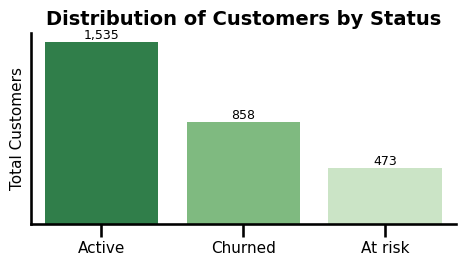

In [7]:
df_q3_sorted = df_q3.sort_values('total_customers', ascending=False)
plt.figure(figsize=(5,3))
sns.barplot (
    data = df_q3_sorted,
    x='customer_status',
    y='total_customers',
    hue='customer_status',
    palette='Greens_r'
)
plt.title('Distribution of Customers by Status', fontsize=14, weight='bold')
plt.xlabel('')
plt.ylabel('Total Customers', fontsize =11)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=11)
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=9
    )
    ax.set_yticks([])     
sns.despine()
plt.tight_layout()
plt.show()


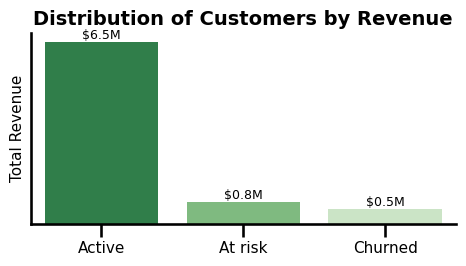

In [8]:
df_q3_sorted_2 = df_q3.sort_values('total_revenue', ascending = False)
plt.figure(figsize=(5,3))
sns.barplot (
    data=df_q3_sorted_2,
    x='customer_status',
    y='total_revenue',
    hue='customer_status',
    palette='Greens_r'
)
plt.title('Distribution of Customers by Revenue', fontsize=14, weight='bold')
plt.xlabel('')
plt.ylabel('Total Revenue', fontsize =11)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=11)
ax.set_yticks([])
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'${height/1e6:.1f}M',
        ha='center',
        va='bottom',
        fontsize=9
    )
sns.despine()
plt.tight_layout()
plt.show()

**Conclusion:**  
Active customers account for the majority of total revenue, as expected. However, at risk customers represent a higher share of revenue than fully churned customers.

**Recommendation:**  
Retention efforts should prioritize at-risk customers, as they still generate meaningful revenue and represent the last opportunity to prevent future revenue loss.


In [9]:
total_customers_3 = df_q3['total_customers'].sum()
total_revenue_3 = df_q3['total_revenue'].sum()

df_q3['pct_customers'] = (df_q3['total_customers'] / total_customers_3) * 100
df_q3['pct_revenue'] = (df_q3['total_revenue'] / total_revenue_3) * 100

summary_table = df_q3[['customer_status',
                       'total_customers',
                       'pct_customers',
                       'total_revenue',
                       'pct_revenue']]

summary_table

,customer_status,total_customers,pct_customers,total_revenue,pct_revenue
0,Active,1535,53.558967,6480668.489,83.380415
1,At risk,473,16.503838,763725.991,9.826114
2,Churned,858,29.937195,528016.424,6.793470


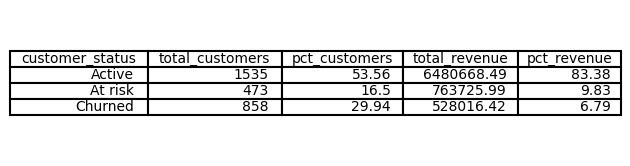

In [10]:
fig, ax = plt.subplots(figsize=(5,2))
ax.axis('off')

table_data = summary_table.round(2)
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data.columns))))
plt.tight_layout()
plt.savefig("data/revenue_by_status.png", dpi=300, bbox_inches='tight')
plt.show()

#### Q4: Is customer churn risk associated with Average Order Value (AOV), when comparing customers in the lowest and highest AOV quartiles, considering only customers with at least two invoices?

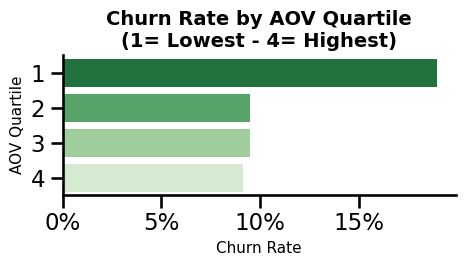

In [11]:
df_q4['aov_quartile'] = df_q4['aov_quartile'].astype(str)
plt.figure(figsize=(5,3))
sns.barplot(
    data=df_q4,
    x='churn_rate',
    y='aov_quartile',
    hue='aov_quartile',
    palette="Greens_r"
)
plt.title('Churn Rate by AOV Quartile\n(1= Lowest - 4= Highest)', fontsize=14, weight='bold')
plt.xlabel('Churn Rate', fontsize =11)
plt.ylabel('AOV Quartile', fontsize =11)
sns.despine()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(lambda x, pos: f'{x:.0%}')
plt.show()


**Conclusion:**  
Customers in the lowest AOV quartile exhibit a noticeably higher churn rate compared to all other AOV segments, while churn differences among higher AOV quartiles are relatively small.

**Recommendation:**  
Retention and engagement strategies should focus primarily on low AOV customers to reduce early churn and increase customer lifetime value.

#### Q5: How does churn rate vary across customer quartiles based on purchase frequency (invoices per active month) among customers with at least two invoices?

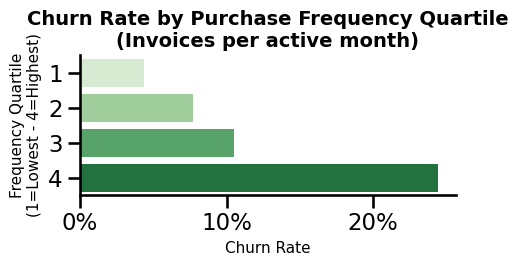

In [12]:
df_q5['frequency_quartile'] = df_q5['frequency_quartile'].astype(str)

plt.figure(figsize=(5,3))
sns.barplot(
    data=df_q5,
    x='churn_rate',
    y='frequency_quartile',
    hue='frequency_quartile',
    palette='Greens'
)

plt.title('Churn Rate by Purchase Frequency Quartile\n(Invoices per active month)', fontsize=14, weight="bold")
plt.xlabel('Churn Rate', fontsize=11)
plt.ylabel('Frequency Quartile\n(1=Lowest - 4=Highest)', fontsize=11)
sns.despine()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(lambda x, pos: f'{x:.0%}')
plt.show()

**Conclusion:**  
Customers with the highest purchase frequency exhibit the highest churn rates, suggesting that frequent purchasing does not necessarily translate into long term loyalty.

**Recommendation:**  
High frequency customers should be monitored for early churn signals, as intense short term activity may indicate transactional behavior rather than sustained engagement.

#### Q6: Within each country, what proportion of churn eligible customers and revenue is lost due to churn?

This section analyzes churn impact at the country level from two complementary perspectives:

- Proportional impact: The share of churn customers and revenue lost within each country (Top 5 countries with most customers)
- Absolute exposure: The total amount of revenue associated with customers (Top 5 countries with most total revenue)

In [13]:
top_countries_by_customers = (
    df_q6
    .sort_values('total_customers', ascending=False)
    .head(5)
    .sort_values('churned_rate')
)
top_countries_by_customers

,country,total_customers,churned_customers,churned_rate,total_revenue,churned_revenue,revenue_churn_rate
16,France,30,4.0,0.1333,133187.080,773.930,0.005811
13,Netherlands,13,3.0,0.2308,264726.290,1446.900,0.005466
4,Germany,45,12.0,0.2667,171184.891,10443.071,0.061005
0,United Kingdom,2665,797.0,0.2991,6545047.663,421544.533,0.064407
7,Spain,14,7.0,0.5000,33300.850,2401.450,0.072114


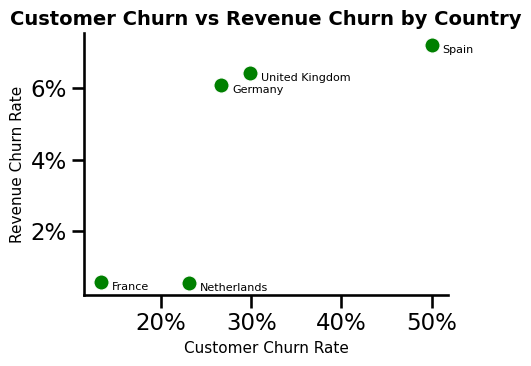

In [14]:
plt.figure(figsize=(5,4))
sns.scatterplot(
    data=top_countries_by_customers,
    x='churned_rate',
    y='revenue_churn_rate',
    s=120,
    color='green'
)
plt.title('Customer Churn vs Revenue Churn by Country', fontsize=14, weight='bold')
plt.xlabel('Customer Churn Rate', fontsize=11)
plt.ylabel('Revenue Churn Rate', fontsize=11)
plt.gca().xaxis.set_major_formatter(lambda x, pos: f'{x:.0%}')
plt.gca().yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')
sns.despine()
plt.tight_layout()
for _, row in top_countries_by_customers.iterrows():
    plt.text(
        row['churned_rate'] + 0.012,
        row['revenue_churn_rate'],
        row['country'],
        fontsize=8,
        ha='left',
        va='top'
    )
plt.show()


While the previous visualization focused on countries with the largest customer bases to ensure rate stability, the following chart highlights the countries with the highest total revenue exposure, regardless of customer volume.

**Conclusion:**  
Customer churn and revenue churn do not always move together across countries.
Some markets lose many customers but relatively little revenue, indicating churn is concentrated among lower value customers.

**Recommendation:**  
Prioritize and focus on selective retention rather than broad campaigns in markets with high customer churn but low revenue impact.
Retention strategies should be country specific.
Retention should prioritize countries where churn results in higher relative revenue loss.

Q7: Which customer segments account for the largest share of potential revenue loss, and therefore should be prioritized for retention efforts?

In [15]:
q7_plot = (df_q7
    .sort_values("revenue_exposed_to_churn", ascending=False)
)

In [16]:
q7_plot['segment'] = ('Rev Seg' + q7_plot['revenue_segment'].astype(str) + '(High→Low) | Inactivity Seg' + q7_plot['inactivity_segment'].astype(str)
)

In [17]:
heatmap_data = q7_plot.pivot(
    index='inactivity_segment',
    columns='revenue_segment',
    values='revenue_exposed_to_churn'
)

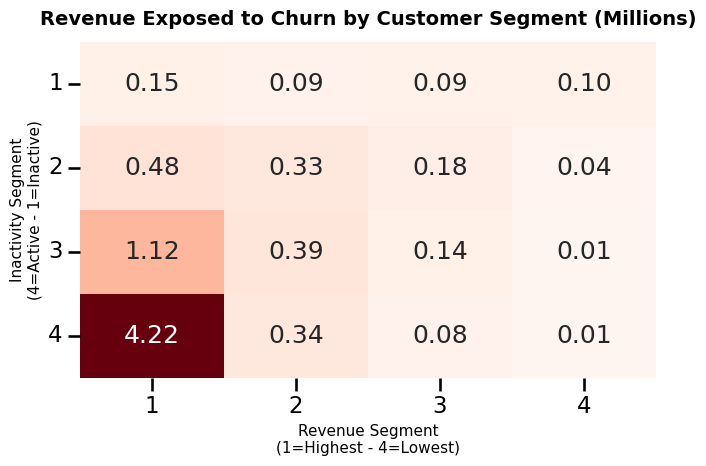

In [18]:
heatmap_data_m = heatmap_data / 1_000_000

plt.figure(figsize=(7,5))
sns.heatmap(
    heatmap_data_m,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar=False
)
plt.title(
    'Revenue Exposed to Churn by Customer Segment (Millions)',
    fontsize=14,
    weight='bold',
    pad=12
)
plt.xlabel('Revenue Segment\n(1=Highest - 4=Lowest)', fontsize=11)
plt.ylabel('Inactivity Segment\n(4=Active - 1=Inactive)', fontsize=11)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("data/q7_revenue_exposure.png", dpi=300, bbox_inches="tight")
plt.show()


**Note:** 

Revenue segments are ordered from highest (1) to lowest (4) customer value. 

Inactivity segments are ordered from most inactive (1) to most active (4).

**Conclusion:**  
The largest share of potential churned revenue is concentrated among high revenue customers who also exhibit high inactivity levels.

**Recommendation:**  
Retention efforts should prioritize high revenue and high inactivity segments, rather than focusing solely on the most inactive customers, as small improvements in retention within these groups can prevent disproportionate revenue loss.


## Additional Business Context: Revenue Concentration by Country

This section complements the churn analysis by highlighting total revenue concentration across countries. Ranking countries by total revenue rather than customer volume to identify markets with high financial importance,
even when current churn exposure is low.

In [19]:
top_countries_by_revenue = (
    df_q6
    .sort_values('total_revenue', ascending=False)
    .head(5)
    .sort_values('total_revenue', ascending=False)
)
top_countries_by_revenue

,country,total_customers,churned_customers,churned_rate,total_revenue,churned_revenue,revenue_churn_rate
0,United Kingdom,2665,797.0,0.2991,6545047.663,421544.533,0.064407
22,Eire,5,1.0,0.2000,356809.060,107.140,0.000300
13,Netherlands,13,3.0,0.2308,264726.290,1446.900,0.005466
4,Germany,45,12.0,0.2667,171184.891,10443.071,0.061005
16,France,30,4.0,0.1333,133187.080,773.930,0.005811


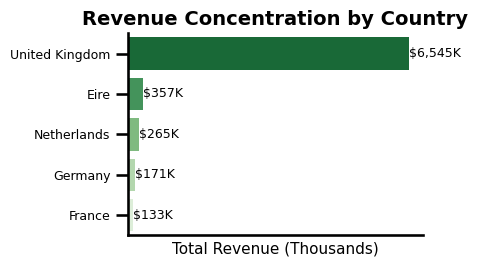

In [20]:
plt.figure(figsize=(5,3))
sns.barplot(
    data=top_countries_by_revenue,
    y='country',
    x='total_revenue',
    hue='country',
    palette='Greens_r',
    legend=False
)
plt.title('Revenue Concentration by Country', fontsize=14, weight='bold')
plt.xlabel('Total Revenue (Thousands)', fontsize=11)
plt.ylabel('')
plt.yticks(fontsize=9)
plt.gca().set_xticks([])
for i, row in top_countries_by_revenue.iterrows():
    plt.text(
        row['total_revenue'],
        row['country'],
        f"${row['total_revenue']/1_000:,.0f}K",
        va='center',
        fontsize=9
    )
sns.despine()
plt.tight_layout()
plt.show()

In [21]:
top_countries_by_revenue_churned_rate = (
    df_q6
    .sort_values('total_revenue', ascending=False)
    .head(5)
    .sort_values('revenue_churn_rate', ascending=False)
)
top_countries_by_revenue_churned_rate

,country,total_customers,churned_customers,churned_rate,total_revenue,churned_revenue,revenue_churn_rate
0,United Kingdom,2665,797.0,0.2991,6545047.663,421544.533,0.064407
4,Germany,45,12.0,0.2667,171184.891,10443.071,0.061005
16,France,30,4.0,0.1333,133187.080,773.930,0.005811
13,Netherlands,13,3.0,0.2308,264726.290,1446.900,0.005466
22,Eire,5,1.0,0.2000,356809.060,107.140,0.000300


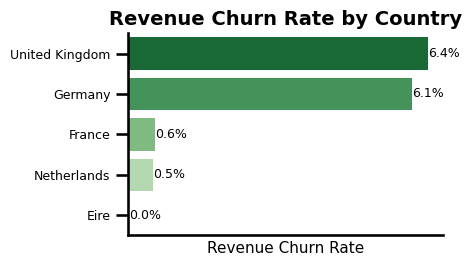

In [22]:
plt.figure(figsize=(5,3))
sns.barplot(
    data=top_countries_by_revenue_churned_rate,
    x='revenue_churn_rate',
    y='country',
    hue='country',
    palette='Greens_r'
)
plt.title('Revenue Churn Rate by Country', fontsize=14, weight='bold')
plt.xlabel('Revenue Churn Rate', fontsize=11)
plt.ylabel('')
plt.yticks(fontsize=9)
plt.gca().set_xticks([])
plt.gca().xaxis.set_major_formatter(lambda x, pos: f'{x:.1%}')
for bar in plt.gca().patches:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f'{width:.1%}',
        va='center',
        ha='left',
        fontsize=9
    )
sns.despine()
plt.tight_layout()
plt.show()

**Conclusion:**

Eire (Ireland) generates disproportionately high revenue with very few customers and minimal revenue churn.

Despite low current churn exposure, Ireland represents a strategic market where retention and relationship management are critical due to revenue concentration risk.

Losing even one Irish customer would have an outsized revenue impact.

This insight would not be visible using churn rates alone.

## Executive Summary

This analysis examines customer churn from multiple angles: 
- Customer value
- Purchasing behavior
- Geographic distribution
- Inactivity risk

Objective: Identifying where retention efforts can generate the greatest business impact.

Rather than focusing only on customers who have already churned, the analysis prioritizes revenue exposure and early inactivity signals across customer segments.

### Business Insights

- Churn risk is strongly linked to customer value and behavioral stability.
- Lower value customers churn more frequently, while high value customers represent the greatest revenue risk when early inactivity emerges.
- High purchase frequency alone does not guarantee loyalty. Customers with intense short term purchasing patterns tend to exhibit higher churn rates, suggesting that frequency without long term engagement may signal transactional rather than loyal behavior.
- Churn impact varies significantly by country, highlighting the importance of evaluating churn through a revenue lens rather than customer volume alone.

### Strategic Implications

- The analysis shows that churn prevention efforts should be prioritized based on revenue exposure and early behavioral signals, rather than focusing exclusively on customers who have already fully churned. 
- These results suggest that churn risk is driven not by purchase activity alone, but by the combination of purchase value and behavioral stability over time.
- Proactive retention actions aimed at high value customers with emerging inactivity patterns are likely to deliver the strongest business impact.


### Next Steps

- Develop a predictive model using inactivity, purchase frequency and revenue related features to identify churn risk earlier in the customer lifecycle.
- Estimate the financial impact of reducing churn within high value customer segments.
- Analyz cheurn behavior by period to identify structural or temporal patterns.
- Translate key insights into an interactive dashboard.
- Implement a recurring churn monitoring framework to track risk segments over time.